In [1]:
####import libraries

import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc, brier_score_loss

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier
import catboost as cb
import clean_text as ct

#### Dataset import and some quick exploration

In [2]:
tweets = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


In [3]:
clean_text = ct.CleanText()
tweets["text"] = clean_text.fit_transform(tweets.text)
tweets = tweets.loc[(~tweets.text.isnull()), :]

In [4]:
#tweets.to_csv("clean_tweets.csv",index=False) # save once processed
# tweets = pd.read_csv("clean_tweets.csv")
# tweets.head()

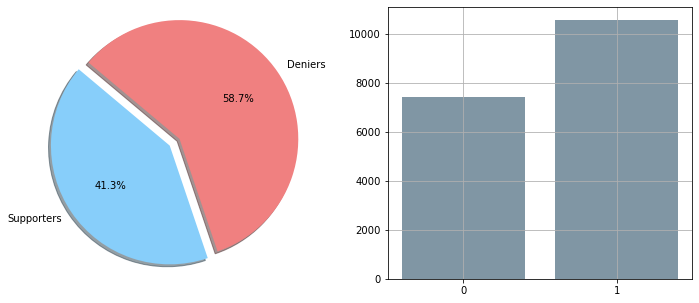

In [5]:
# Data to plot
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2)

labels = 'Supporters', 'Deniers'
sizes = len(tweets.label.values[tweets.label.values==0]),len(tweets.label.values[tweets.label.values==1])
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
ax[0].pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

ax[0].axis('equal')


labels, counts = np.unique(tweets.label.values, return_counts=True)
ax[1].bar(labels, counts, align='center',color='#607c8e',alpha=0.8)
ax[1].set_xticks(labels)
ax[1].grid()


plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

###### Bag-Of-Words and Scaling

![BagOfWords](https://www.novuslight.com/uploads/n/BagofWords.jpg)

In [7]:
#Bigrams representation (1,2)
BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, 
                                 ngram_range=(1,2),            
                                 min_df = 10)

BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)


#### BE CAREFUL!!!! ####
scaler_BOW = MaxAbsScaler()  ####<-- For BOW scaling is reduntant, but I do it in matters of consistency.

X_train = scaler_BOW.fit_transform(BOW_train)
X_test = scaler_BOW.transform(BOW_test)

In [8]:
class Majority_vote():
    """
    averaging all models
    """
    def __init__(self,models,threshold=None):
        self.base_models = models
        if threshold:
            self.threshold = threshold
        else:
            self.threshold = 0.5
              
    
    def fit(self,X_train,y_train):
        for model in self.base_models:       
            model.fit(X_train,y_train)

    def predict_score(self,X):
        s = []
        for k,model in enumerate(self.base_models):
            pred = model.predict_proba(X)[:,1]
            s.append(pred)
        s = np.array(s)
        return(np.sum(s,axis=0)/len(self.base_models))
    
    def predict(self,X):
        score = self.predict_score(X)
        pred = np.zeros(X.shape[0])
        pred[score>=self.threshold] = 1
        return pred

![dd](https://miro.medium.com/max/700/1*EekXroXi99N05jcskdPsIg.png)

In [9]:
estimators = [RandomForestClassifier(**{'bootstrap': True,'max_depth': None,'max_features': 'log2',
                                        'min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 300,
                                        'random_state':17}),
              SVC(**{'C': 100, 'gamma': 0.001, 'kernel': 'rbf','probability':True,'random_state':17}),
              LogisticRegression(**{'C':1,'max_iter':1000, 'multi_class':"ovr", 'solver':"saga",'random_state':17}),
              cb.CatBoostClassifier(**{"border_count": 200, "depth": 6, "l2_leaf_reg": 10,
                                       "learning_rate": 0.3, "n_estimators": 1000,'verbose':0,'random_state':17})]

In [10]:
# kfcv = KFold(n_splits=3,shuffle=True,random_state=101)

In [11]:
# best = 0
# threshold = 0.5

# for t in tqdm_notebook([0.4,0.45,0.5,0.55,0.6]):

#     score_accuracy = []
#     for train_index, val_index in kfcv.split(X_train,y_train):
#         XX_train, XX_val = X_train[train_index], X_train[val_index]
#         yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
#         clf = Majority_vote(estimators,threshold=t)
#         clf.fit(XX_train,yy_train)
#         pred = clf.predict(XX_val)
#         accuracy = accuracy_score(yy_val,pred)
#         score_accuracy.append(accuracy)
        
#     if np.mean(score_accuracy) >= best:
#         best = np.mean(score_accuracy)
#         threshold = t

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [12]:
# print(best)
# print(threshold)

0.911778913573528
0.55


In [13]:
# clf = Majority_vote(estimators,threshold=threshold)
# clf.fit(X_train,y_train)

In [14]:
def plot_figure(X,y,clf):
    '''Plots Precision-Recall & ROC curves'''

    y_score = clf.predict_score(X)
    average_precision = average_precision_score(y, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))




    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    #plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    
    plt.show()

#######################

Accuracy: 0.9203
Precision: 0.9376
Recall: 0.9275
F1_score: 0.9325
F2_score: 0.9295
F5_score: 0.9279
AUC_score: 0.9741
1-Brier_score: 0.9396

#######################

Average precision-recall score: 0.98


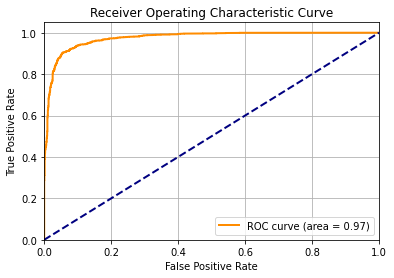

In [15]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=5)
y_score = clf.predict_score(X_test)
auc_score = roc_auc_score(y_test,y_score)
brier_score = brier_score_loss(y_test, y_score)


print('#######################\n')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))
print('F5_score: {}'.format(round(f5,4)))
print('AUC_score: {}'.format(round(auc_score,4)))
print('1-Brier_score: {}'.format(round(1-brier_score,4)))
print()
print('#######################\n')


plot_figure(X_test,y_test,clf)

#######################

Accuracy: 0.9217
Precision: 0.928
Recall: 0.9411
F1_score: 0.9345
F2_score: 0.9384
F5_score: 0.9406
AUC_score: 0.9741
1-Brier_score: 0.9396

#######################

Average precision-recall score: 0.98


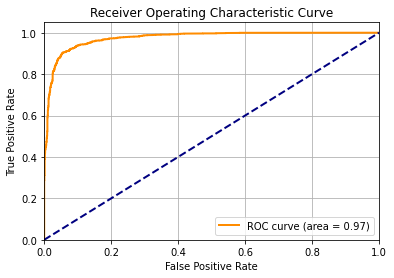

In [16]:
clf = Majority_vote(estimators)
clf.fit(X_train,y_train)

pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=5)
y_score = clf.predict_score(X_test)
auc_score = roc_auc_score(y_test,y_score)
brier_score = brier_score_loss(y_test, y_score)


print('#######################\n')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))
print('F5_score: {}'.format(round(f5,4)))
print('AUC_score: {}'.format(round(auc_score,4)))
print('1-Brier_score: {}'.format(round(1-brier_score,4)))
print()
print('#######################\n')


plot_figure(X_test,y_test,clf)